# Inference

- Run inference on the test dataset.
- Mainly for testing your model is doing ok visually.
- This is not meant to be used in production (see [Export_and_Packing](./5_Export_and_Packing.ipynb)).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import tqdm
import torch
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Nucleus")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

In [2]:
# Select the model
model_name = '2018.11.04-17:31:08'
model_path = model_dir / model_name

# Set some configurations
config['MODEL']['DEVICE'] = "cpu"
config['DATALOADER']['NUM_WORKERS'] = 4
config['TEST']['IMS_PER_BATCH'] = 1
config['SOLVER']['IMS_PER_BATCH'] = 1
batch_to_load = 4

# Build the model
model = maskflow.inference.build_model(config, model_path)

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=False)
data = [datum for _, datum in zip(range(batch_to_load), data_loader)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

# Run inference
predictions = []
images = []
ground_truth = []
for batch_image, batch_target, batch_idx in data:
    batch_image = batch_image.to(config['MODEL']['DEVICE'])
    with torch.no_grad():
        prediction = model(batch_image)
        prediction = [o.to('cpu') for o in prediction]
        predictions.extend(prediction)
        images.extend([im for im in batch_image.tensors])
        ground_truth.extend(batch_target)
        
images = np.array([o.to('cpu').numpy() for o in images])
len(images)

2018-11-06 09:07:16,141:INFO:maskrcnn_benchmark.utils.checkpoint: Loading checkpoint from /home/hadim/.data/Neural_Network/Maskflow/Nucleus/Models/2018.11.04-17:31:08/model_0001200.pth


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


4

48
tensor([0.9968, 0.9957, 0.9956, 0.9949, 0.9943, 0.9937, 0.9932, 0.9932, 0.9930,
        0.9926, 0.9925, 0.9921, 0.9918, 0.9916, 0.9910, 0.9864, 0.9862, 0.9832,
        0.9829, 0.9813, 0.9809, 0.9796, 0.9793, 0.9793, 0.9767, 0.9738, 0.9735,
        0.9718, 0.9675, 0.9662, 0.9604, 0.9596, 0.9541, 0.9530, 0.9493, 0.9445,
        0.9417, 0.9414, 0.9383, 0.9320, 0.9200, 0.9155, 0.9144, 0.8577, 0.8140,
        0.8126, 0.7625, 0.7343])


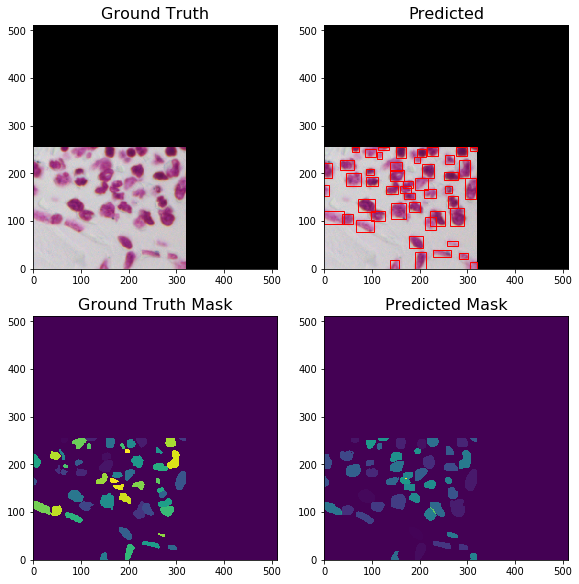

In [25]:
# Show prediction
idx = 0
image = images[idx]
prediction = predictions[idx]
gt = ground_truth[idx]

prediction = maskflow.inference.post_process_predictions(prediction, image,
                                                         confidence_threshold=0.7,
                                                         mask_threshold=0.5)

print(prediction.bbox.shape[0])
print(prediction.get_field('scores'))

_ = maskflow.viz.display_prediction_and_gt(image, prediction, gt, class_names=config['CLASS_NAMES'],
                                           pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                           pixel_std=config['INPUT']['PIXEL_STD'])